## **Import Libraries**

In [123]:
import numpy as np
import pandas as pd
from scipy.linalg import orth

import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

## **Define functions for CoP**

In [124]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def svd_flip(u, v, u_based_decision=True):
    """Sign correction to ensure deterministic output from SVD.

    Adjusts the columns of u and the rows of v such that the loadings in the
    columns in u that are largest in absolute value are always positive.
    """
    
    if u_based_decision:
        # columns of u, rows of v
        max_abs_cols = np.argmax(np.abs(u), axis=0)
        signs = np.sign(u[max_abs_cols, range(u.shape[1])])
        u *= signs
        v *= signs[:, np.newaxis]
    else:
        # rows of v, columns of u
        max_abs_rows = np.argmax(np.abs(v), axis=1)
        signs = np.sign(v[range(v.shape[0]), max_abs_rows])
        u *= signs
        v *= signs[:, np.newaxis]
    return u, v

def coherence_pursuit(D0):
    '''
        N1 : The dimension of ambient space
        n1 : The number of inliers
        n2 : The number of outliers
        r : The rank of low rank matrix
    '''
    N1, N_sample = D0.shape

    # 1. Subtract the meidian
    D = D0 - np.median(D0, axis = 1, keepdims=True)
    # D = D0

    # 2. Compute L2 norm of r-th columns of D0
    T = np.sum(D ** 2, axis = 0) ** 0.5 # rms amplitude
    T_aug = np.tile(T, (N1, 1)) # For element-wise division

    # 3. Normalize the columns of M0
    X = D/T_aug

    # 4. Compute the pairwise mutual coherence matrix
    G = np.matmul(X.T, X)

    # 5. Compute the coherence vector g as the L1-norm
    G = G - np.diag(np.diag(G))
    p = np.sum(G ** 2, axis = 0)
    p = p/np.max(p)


    # 7. Set # of samples by CoP algirithm to form the recovered subspace
    best_clusterer, cut_off_th = optimal_ncluster_BIC(p)
    # cut_off_th = 0.95
    n = sum(p >= cut_off_th)

    markerline, stemlines, baseline = plt.stem(sorted(p))
    plt.setp(markerline, marker='o', markersize=3, markeredgecolor="k", markeredgewidth=0.5)
    plt.setp(stemlines, linestyle="-", linewidth=0.1, color = 'lightblue')
    plt.setp(baseline, linewidth=0.5)

    plt.plot([0, N_sample],  [cut_off_th, cut_off_th], 'r:')
    plt.title('The elements of vector p')
    plt.grid(True)
    plt.show()

    print(f'Threshold for cut-off: {cut_off_th}')
    print(f'# of samples by CoP algirithm to form the recovered subspace: {n}')
    
    b = np.argsort(p)
    b = b[::-1]
    Y = D[:, b[:n]]

    index_inliners = np.zeros(N_sample)
    index_inliners[b[:n]] = 1

    # Compute the factor by Singular Value Decomposition
    U, S, Vt = np.linalg.svd(Y.T, full_matrices = False)

    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S**2) / (n - 1)
    singular_values_ = S.copy()  # Store the singular values.

    return T, components_, singular_values_, explained_variance_, D0[:, b[:n]]

def optimal_ncluster_BIC(p, n_range = range(1, 5)):
    clusterer_list, bic_list = [], []
    for k in n_range:
        clusterer = KMeans(n_clusters = k, n_init="auto", random_state=10, max_iter=300)
        clusterer.fit(p.reshape(-1, 1))
        clusterer_list.append(clusterer)
        
        cluster_labels = clusterer.predict(p.reshape(-1, 1))
        
        bic = 0
        n = p.shape[0]
        for ind in np.unique(cluster_labels):
            temp_p = p[cluster_labels == ind]
            ni = sum(cluster_labels == ind)
            term1 = ni * np.log(ni/n)
            term2 = ni/2 * np.log(2 * np.pi)
            term3 = ni/2 * np.log(np.var(temp_p))
            term4 = (ni - k)/2
            bic = bic + term1 - term2 - term3 - term4
        
        bic = bic - 1/2 * k * np.log(n)
        bic_list.append(bic)
    

    best_ind = np.argmax(bic_list)
    best_clusterer = clusterer_list[best_ind]

    if 1:
        plt.plot(n_range, bic_list)
        plt.plot(best_ind+1, bic_list[best_ind], 'ro')
        plt.xlabel('# of Cluster')
        plt.ylabel('BIC')
        plt.grid(True)
        plt.show()

    # 6. Perform K-means clustering and select cut-off threshold (cut_off_th)
    cluster_labels = best_clusterer.predict(p.reshape(-1, 1))
    p_target = 0
    for ind in np.unique(cluster_labels):
        temp_p = p[cluster_labels == ind]
        if temp_p.mean() > p_target:
            ind_target = ind
            p_target = temp_p.mean()

    cut_off_th = p[cluster_labels == ind_target].min()

    return best_clusterer, cut_off_th

def match_sign_vector(y_true, y):
    for i in range(y_true.shape[0]):
        if y_true[i, 0] * y[i, 0] < 0:
            y[i, :] = - y[i, :]
    return y

## **Import Datasets**

In [125]:
# N_train = 500
N_train = 900

# Define filename for save
fn_sv = f'N_train{N_train}'

import pickle

# Load pickle of settings
with open(fn_sv + '_option.pkl', 'rb') as fw:
    data = pickle.load(fw)
# Define variable from dictionary
for var in data.keys():
    exec("{} = data['{}']".format(var, var))
'''
    N_train, df_train_type_ratio, data_type, dict_map_type
'''

# Load pickle of trainset
with open(fn_sv + '_train.pkl', 'rb') as fw:
    data = pickle.load(fw)
# Define variable from dictionary
for var in data.keys():
    exec("{} = data['{}']".format(var, var))
'''
    df_train_sets, df_train_labels
'''

'\n    df_train_sets, df_train_labels\n'

In [126]:
display(df_train_type_ratio)
print(df_train_type_ratio.sum())

,Ratio,N_data,Total count
normal,0.6,540,659
drift,0.1,90,112
minor,0.1,90,113
square,0.1,90,154
trend,0.1,90,164


Ratio             1.0
N_data          900.0
Total count    1202.0
dtype: float64


In [127]:
dict_map_type

{'normal': 0,
 'drift': 1,
 'minor': 2,
 'square': 3,
 'trend': 4,
 'damage2': 5,
 'damage4': 6}

In [128]:
i_dataset = 0

dict_index = {}
for name, ind in dict_map_type.items():
    dict_index[name] = np.where(df_train_labels[i_dataset].to_numpy() == ind)

freq = df_train_sets[i_dataset].index.to_numpy()
D = df_train_sets[i_dataset].values
print(f'All_data.shape: {D.shape}')

All_data.shape: (1597, 900)


Normal_data.shape: (1597, 540)


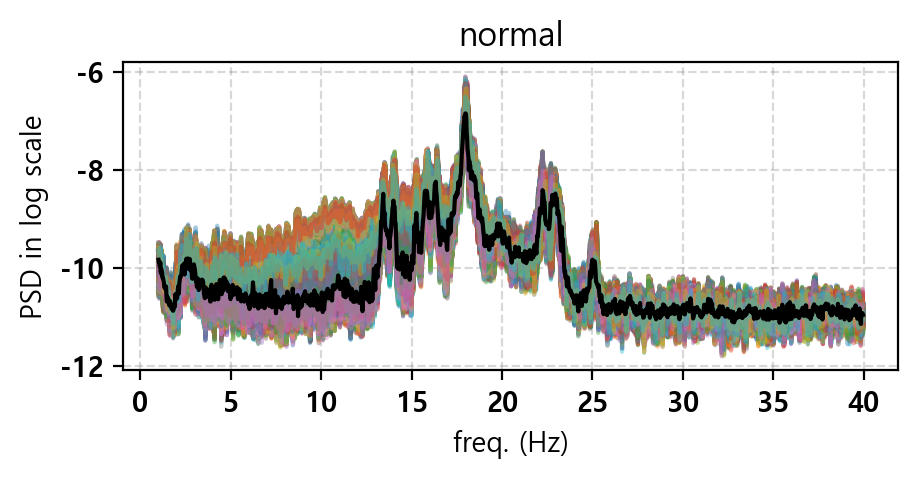

In [129]:
data_type = 'normal'
D_true = df_train_sets[i_dataset].values[:, dict_index[data_type]].squeeze()
print(f'Normal_data.shape: {D_true.shape}')


plt.plot(freq, D_true, alpha=0.4)
plt.plot(freq, np.median(D_true, axis = 1), color = 'k', label = 'Median')
plt.xlabel('freq. (Hz)')
plt.ylabel('PSD in log scale')
plt.grid(color='gray', alpha=0.3, linestyle='--')
plt.title(data_type)
plt.show()

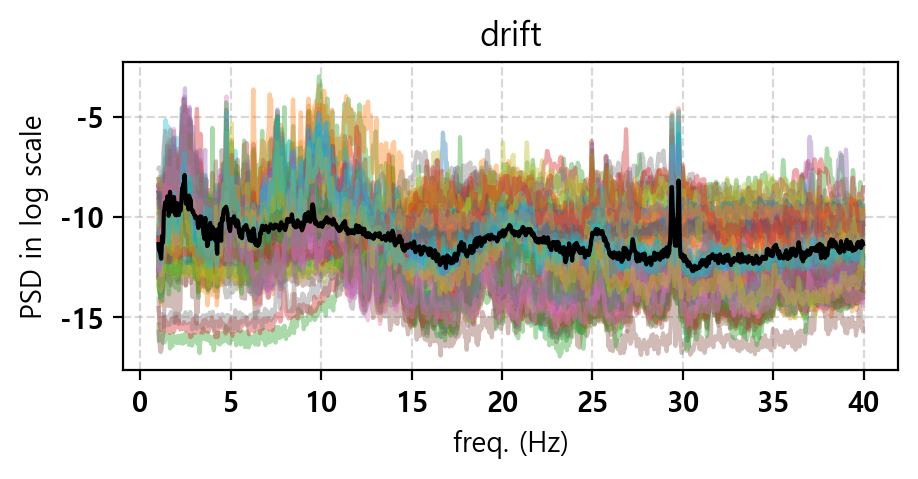

In [130]:
data_type = 'drift'
D_drift = df_train_sets[i_dataset].values[:, dict_index[data_type]].squeeze()


plt.plot(freq, X, alpha=0.4)
plt.plot(freq, np.median(X, axis = 1), color = 'k', label = 'Median')
plt.xlabel('freq. (Hz)')
plt.ylabel('PSD in log scale')
plt.grid(color='gray', alpha=0.3, linestyle='--')
plt.title(data_type)
plt.show()

## **Perform Coherenece Pursuit**

c:\Users\seung\anaconda3\envs\Robust_OD_port_infras\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\seung\anaconda3\envs\Robust_OD_port_infras\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\seung\anaconda3\envs\Robust_OD_port_infras\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\seung\anaconda3\envs\Robust_OD_port_infras\lib

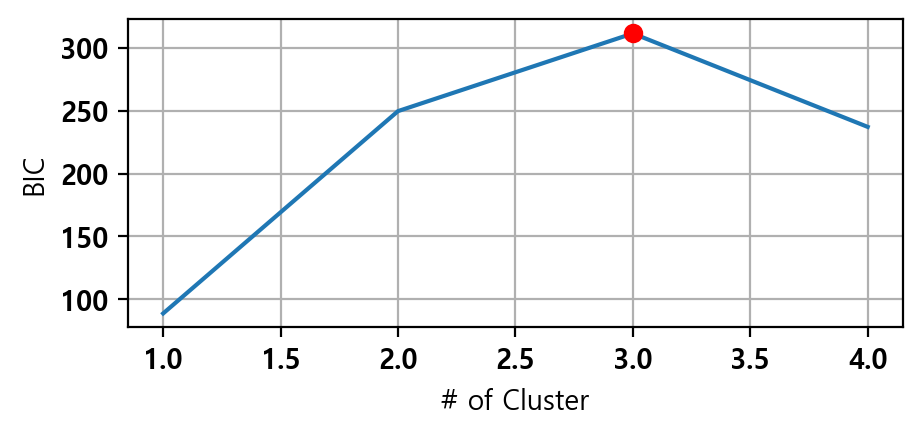

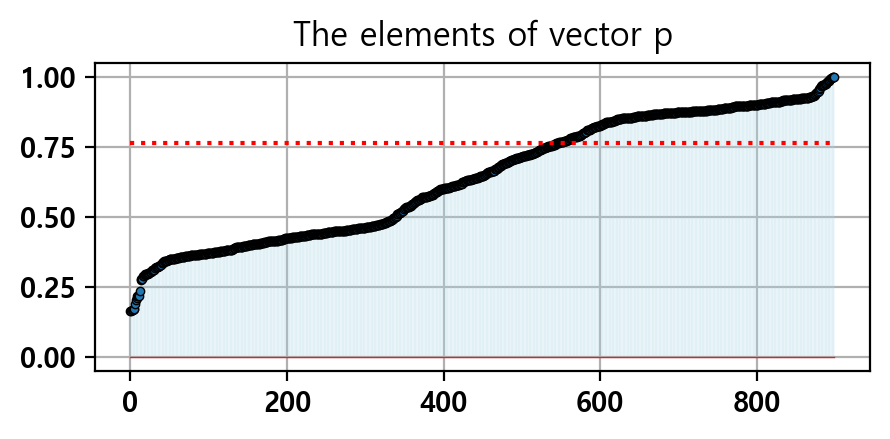

Threshold for cut-off: 0.7639942814757232
# of samples by CoP algirithm to form the recovered subspace: 353


In [131]:
T, Cop_components_, Cop_singular_values_, Cop_explained_variance_, Cop_inliers = coherence_pursuit(D)
# print(Cop_explained_variance_)

In [132]:
print(f'Cop_components_.shape: {Cop_components_.shape}')
Cop_components_[0, :]

Cop_components_.shape: (353, 1597)


array([-0.01894913, -0.01910174, -0.01889309, ..., -0.01961178,
       -0.01912701, -0.01855113])

In [133]:
from sklearn.decomposition import PCA
pca_DGP = PCA(n_components=5)
pca_DGP.fit(D_true.T)
print(f'pca_DGP_components_.shape: {pca_DGP.components_.shape}')
pca_DGP.components_[0, :]

pca_DGP_components_.shape: (5, 1597)


array([ 0.01475295,  0.01117175,  0.00962211, ..., -0.00205859,
       -0.00479948, -0.00470702])

In [134]:
from sklearn.decomposition import PCA
pca_conv = PCA(n_components=5)
pca_conv.fit(D.T)
print(f'pca_DGP_components_.shape: {pca_conv.components_.shape}')
pca_conv.components_[0, :]

pca_DGP_components_.shape: (5, 1597)


array([-0.01624248, -0.01661996, -0.01594326, ..., -0.02100653,
       -0.02057506, -0.02000376])

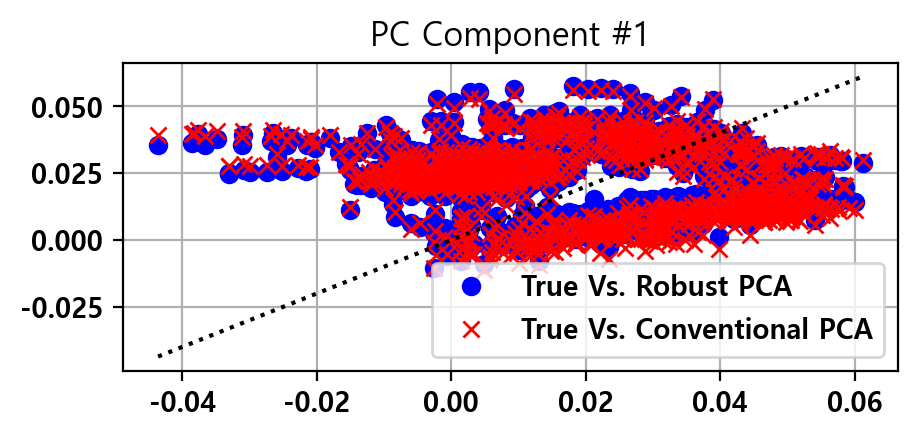

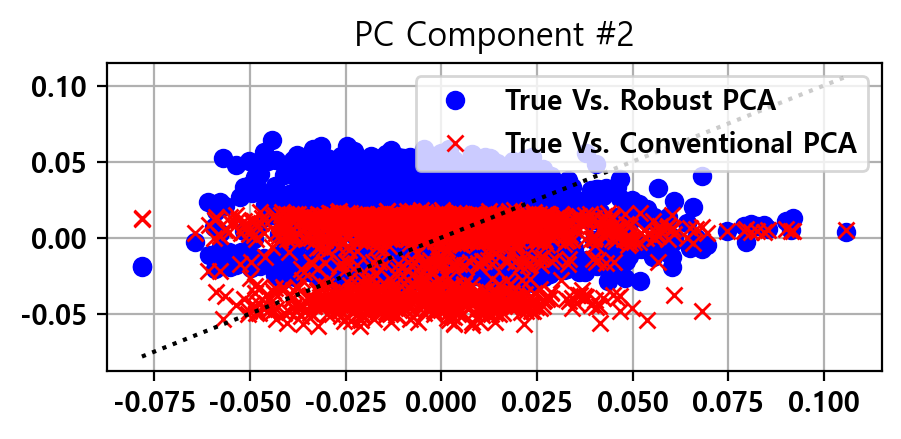

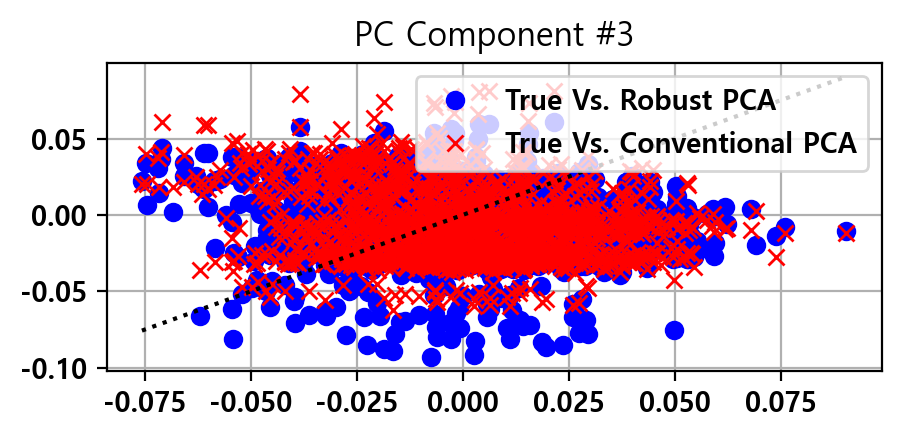

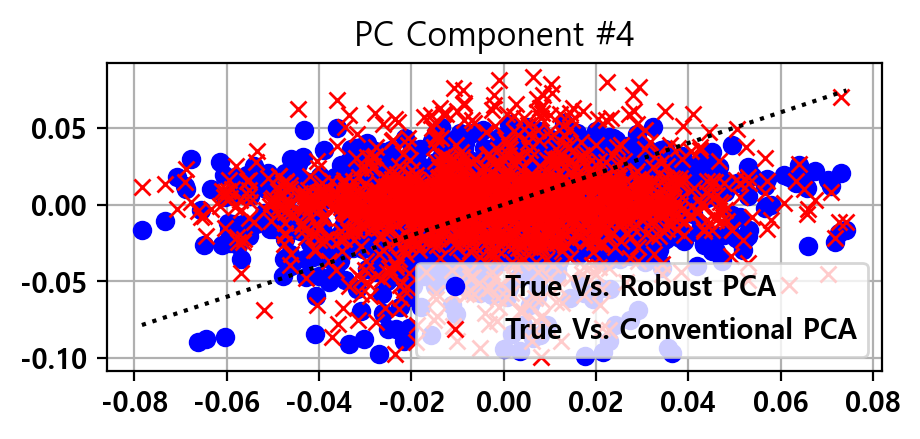

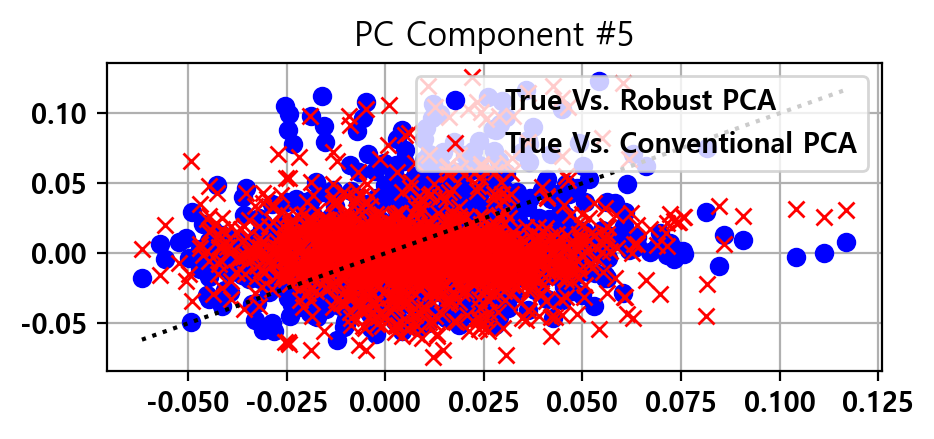

In [135]:
y_true = pca_DGP.components_

y_proposed = match_sign_vector(y_true, Cop_components_)
y_conventional = match_sign_vector(y_true, pca_conv.components_)

for i in range(5):
    plt.plot(y_true[i, :], y_proposed[i, :], 'bo', label = 'True Vs. Robust PCA')
    plt.plot(y_true[i, :], y_conventional[i, :], 'rx', label = 'True Vs. Conventional PCA')

    x_range = [y_true[i, :].min(), y_true[i, :].max()]
    plt.plot(x_range, x_range, 'k:')
    plt.title(f'PC Component #{i+1}')
    plt.grid(True)
    plt.legend()
    plt.show()